# Manual contributor

This notebook extracts contribution tree data that has been exported manually
(copy-pasted) from openLCA into an Excel file, in the format shown in the
picture below.

<img src="manual_excel_example.png">

In [597]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [598]:
scenario = 'Baseline'
# scenario = 'Baseline_LFP'
# scenario = 'CuFe'
# scenario = 'CuFe_LFP'

In [698]:
categories = pd.read_excel(f'..\{scenario}_contributions.xlsx', 'General')
category = categories.iloc[15, 1]

In [699]:
df = pd.read_excel(f'..\{scenario}_contributions.xlsx', category).dropna()

sub_processes = []

for i,row in df.iterrows():
    if row['Process'].startswith(scenario):
        sub = ' '.join(row['Process'].split(' ')[3:][:-2])
        sub_processes.append([])
        # row['Process'] = f'Direct, {sub}'
        row['Process'] = 'Direct impacts'
        row[df.columns[4]] = row[df.columns[5]]
    if row['Process'] != 'Process':
        row['Sub-process'] = sub
        sub_processes[-1].append(row)

new_rows = []
for sub in sub_processes[::-1]:
    for row in sub:
        new_rows.append(row)

df = pd.DataFrame(new_rows)
df.reset_index(drop=True, inplace=True)

for i,row in df.iterrows():
    split_row = row[1].split(' | ')
    process = split_row[0]
    if process.startswith('market for '):
        process = process[11:]
    elif process.startswith('market group for '):
        process = process[17:]
    elif process.endswith('production'):
        process = process[:-11]
    if 'without water' in process:
        split = process.split(',')
        process = split[0]
    df.loc[i, 'Process'] = process

category_name = categories[categories['Sheet name'] == category]['Impact category'].values[0]
category_units = ''.join(['[', df.columns[4].split('[')[-1]])

In [700]:
process_order = [
    'Direct impacts',
    'sulfuric acid',
    'hydrogen peroxide',
    'sodium hydroxide',
    'hydrogen sulfide',
    'soda ash, dense',
    'quicklime, milled, packed',
    'D2EHPA',
    'Cyanex 272',
    'kerosene',
    'tap water',
    'steam, in chemical industry',
    'electricity, medium voltage',
    'hazardous waste, for underground deposit',
    'hazardous waste, for incineration',
    'wastewater, average',
    'wastewater, unpolluted',
    'copper concentrate, sulfide ore',
    'manganese sulfate',
    'cobalt sulfate',
    'nickel sulfate',
    'lithium carbonate',
    'sodium sulfate, anhydrite'
]

sub_process_order = [
    'Leaching',
    'Solution purification',
    'Mn recovery',
    'Co recovery',
    'Ni recovery',
    'Li recovery',
    'Effluent treatment'
]

for i,row in df.iterrows():
    df.loc[i, 'Primary order'] = process_order.index(row['Process'])
    df.loc[i, 'Secondary order'] = sub_process_order.index(row['Sub-process'])

df.sort_values(by=['Primary order', 'Secondary order'], inplace=True)
# df

In [701]:
pivot_df = df.pivot(index='Sub-process', columns='Process', values=df.columns[4]).fillna(0)
# pivot_df = pivot_df.iloc[:, 7:]
pivot_df = pivot_df.reindex(index=df['Sub-process'].unique(), columns=df['Process'].unique())

y_min = pivot_df.to_numpy().min()
y_max = pivot_df.to_numpy().max()

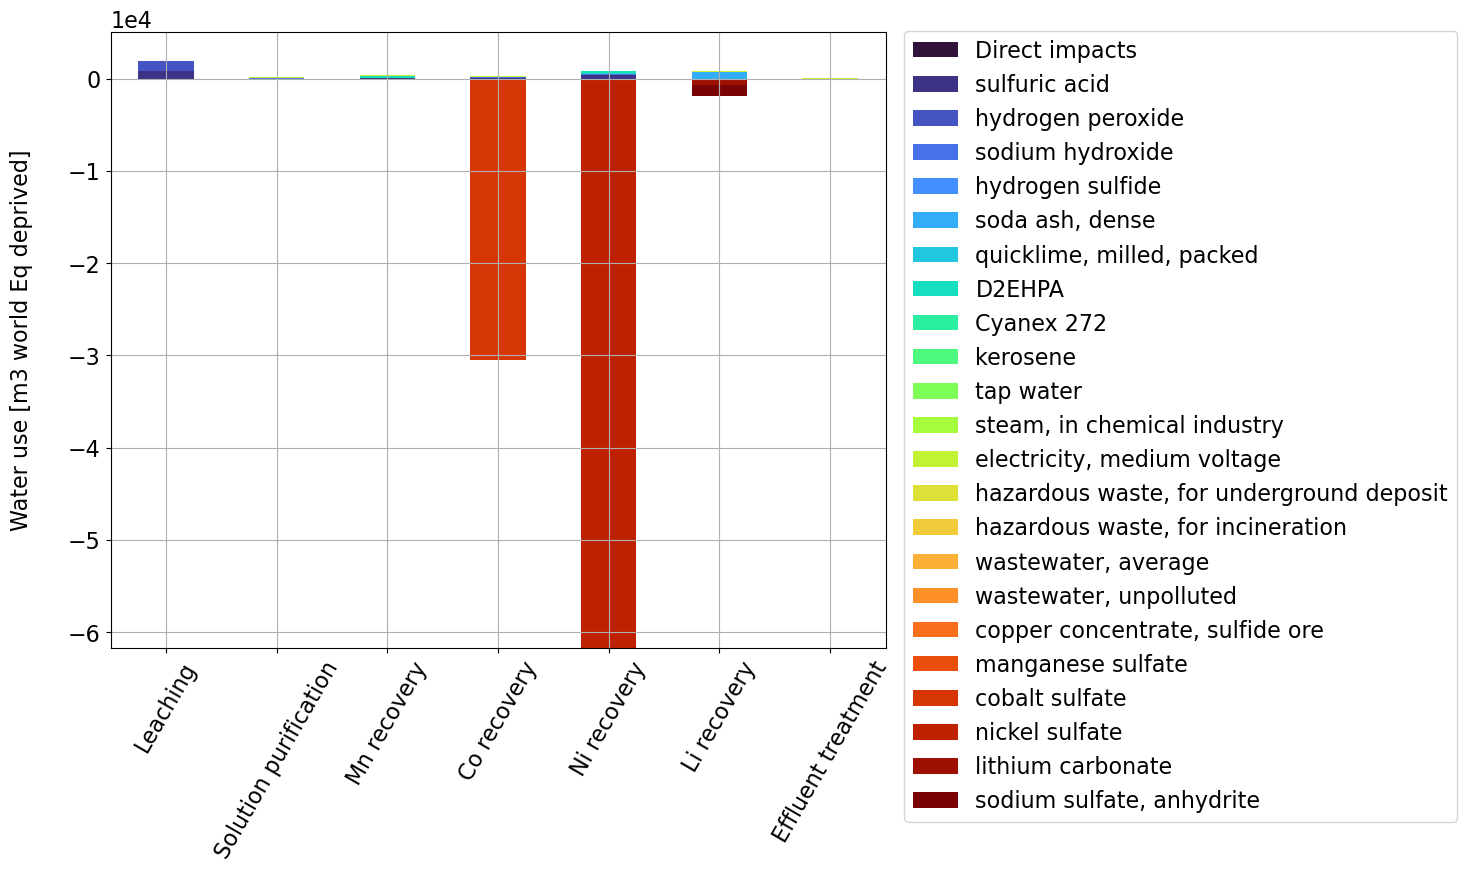

In [704]:
fig, ax = plt.subplots(figsize=(10, 8))

my_cmap = mpl.colormaps['turbo']
mpl.rcParams.update({'font.size': 16})
plt.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))

ax.yaxis.set_label_coords(-0.1, 0.5)
pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=my_cmap)
# plt.ylim([y_min*1.05, y_max*5])
plt.legend(bbox_to_anchor=(1.01, 1.02))
plt.xlabel('')
plt.xticks(rotation=60)
plt.ylabel(category_name + ' ' + category_units)

plt.show()